### Import libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, count, sum, avg, when, round, hour, dayofweek, month, to_date
from pyspark import StorageLevel
import seaborn as sns
import matplotlib.pyplot as plt

### Create Spark session

In [2]:
spark = SparkSession.builder \
    .appName("cc_trans") \
    .config("spark.ui.port", "4040") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.executor.cores", "3") \
    .config("spark.sql.shuffle.partitions", "24") \
    .config("spark.network.timeout", "600s") \
    .config("spark.sql.parquet.datetimeRebaseModeInWrite", "CORRECTED") \
    .config("spark.sql.parquet.int96RebaseModeInWrite", "CORRECTED") \
    .config("spark.sql.legacy.timeParserPolicy", "CORRECTED") \
    .config("mapreduce.fileoutputcommitter.marksuccessfuljobs", "false") \
    .config("spark.sql.parquet.compression.codec", "zstd") \
    .getOrCreate()

### Import data and only select necessary columns
* _Unnamed: 0_ looks like an index column, a running number
* _cc_num_ and _pii_cc_num_ are PII data
* _street_ and _zip_ are too granular. _city_ and _state_ are sufficient
* _merch_zipcode_ is redundant because we already have _merch_lat_ and _merch_long_
* _merch_eff_time_ and _merch_last_update_time_ are not related with transaction behaviour

In [3]:
df = spark.read.format("parquet").load(f"/home/jovyan/work/kaggle/output/part-00000-3cd6bdd7-0ccc-43df-94d6-08df11324869-c000.zstd.parquet")

df.persist(StorageLevel.MEMORY_AND_DISK)

df = df.select(
    col("trans_date_trans_time"),
    col("merchant"),
    col("category"),
    col("amt"),
    col("gender"),
    col("city"),
    col("state"),
    col("lat"),
    col("long"),
    col("city_pop"),
    col("job"),
    col("dob"),
    col("trans_num"),
    col("merch_lat"),
    col("merch_long"),
    col("cc_bic"),
    col("is_fraud")
)

df = df.withColumn("is_fraud", when(col("is_fraud")==True, 1).otherwise(0))

### Visualizations

+--------+-------+----------------+
|is_fraud|  count|fraud_percentage|
+--------+-------+----------------+
|       0|1289169|           99.42|
|       1|   7506|            0.58|
+--------+-------+----------------+



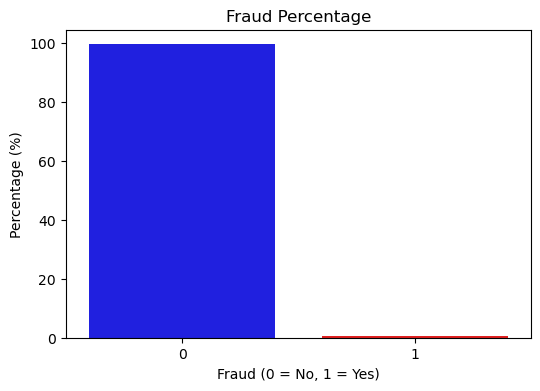

In [4]:
fraud_summary = df.groupBy("is_fraud").agg(count("*").alias("count"))
total_transactions = df.count()
fraud_summary = fraud_summary.withColumn("fraud_percentage", round(col("count") / total_transactions * 100, 2))
fraud_summary.show()
fraud_summary_pd = fraud_summary.toPandas()

plt.figure(figsize=(6,4))
sns.barplot(x="is_fraud", y="fraud_percentage", data=fraud_summary_pd, hue="is_fraud", palette={0: "blue", 1: "red"}, legend=False)
plt.title("Fraud Percentage")
plt.xlabel("Fraud (0 = No, 1 = Yes)")
plt.ylabel("Percentage (%)")
plt.show()

* Less than 1% transactions are classified as fraud transactions

###

+-------------+----------+----------+----------+
|        state|total_txns|fraud_txns|fraud_rate|
+-------------+----------+----------+----------+
|     Delaware|         9|         9|     100.0|
| Rhode Island|       550|        15|      2.73|
|       Alaska|      2120|        36|       1.7|
|       Nevada|      5607|        47|      0.84|
|     Colorado|     13880|       113|      0.81|
|       Oregon|     18597|       149|       0.8|
|    Tennessee|     17554|       140|       0.8|
|     Nebraska|     24168|       180|      0.74|
|        Maine|     16505|       119|      0.72|
|New Hampshire|      8278|        59|      0.71|
+-------------+----------+----------+----------+
only showing top 10 rows



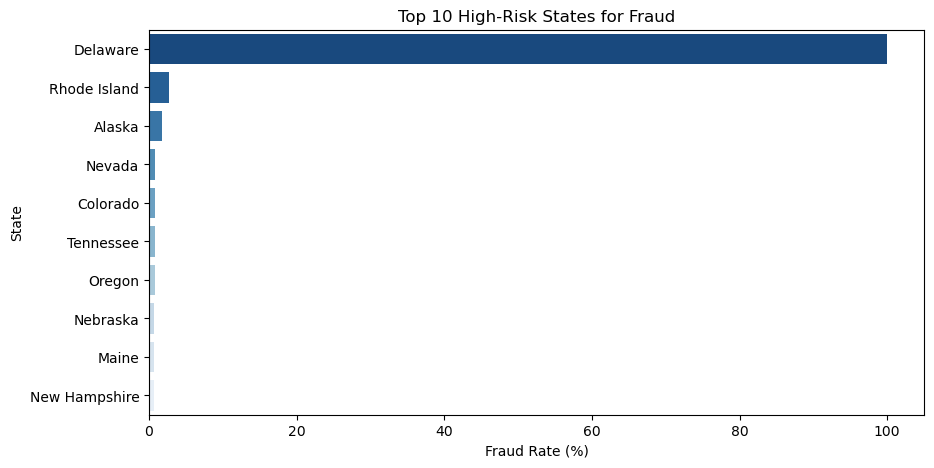

In [5]:
state_fraud = df.groupBy("state").agg(count("*").alias("total_txns"), sum(when(col("is_fraud") == 1, 1).otherwise(0)).alias("fraud_txns")).withColumn("fraud_rate", round(col("fraud_txns") / col("total_txns") * 100, 2)).orderBy(col("fraud_rate").desc())
state_fraud.show(10)
state_fraud_pd = state_fraud.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(y="state", x="fraud_rate", data=state_fraud_pd.head(10), hue="state", palette="Blues_r", dodge=False)
plt.title("Top 10 High-Risk States for Fraud")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("State")
plt.show()

* All transactions from Delaware are fraudulent. The second highest fraud transactions is just 2.73%

###

+--------+----------+-----------+
|is_fraud|   avg_amt|  total_amt|
+--------+----------+-----------+
|       0| 67.667110|87234340.29|
|       1|531.320092| 3988088.61|
+--------+----------+-----------+



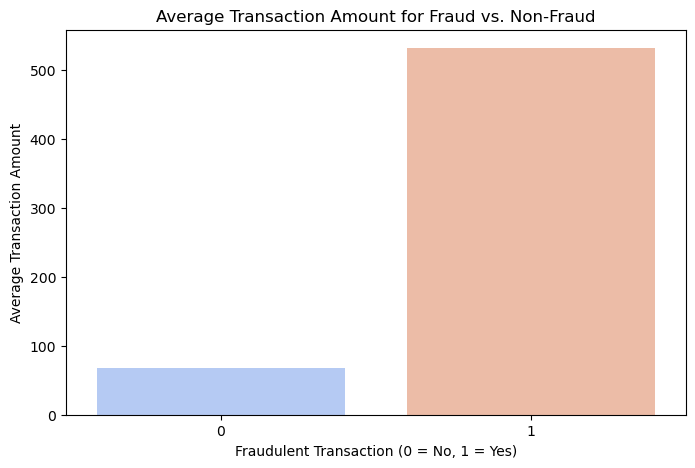

In [6]:
amount_stats = df.groupBy("is_fraud").agg(avg("amt").alias("avg_amt"), round(sum("amt"), 2).alias("total_amt"))
amount_stats.show()
amount_stats_pd = amount_stats.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=amount_stats_pd, x="is_fraud", y="avg_amt", palette="coolwarm", hue="is_fraud", legend=False)
plt.xlabel("Fraudulent Transaction (0 = No, 1 = Yes)")
plt.ylabel("Average Transaction Amount")
plt.title("Average Transaction Amount for Fraud vs. Non-Fraud")
plt.show()

* The average amount of fraudulent transaction is around 500$

###

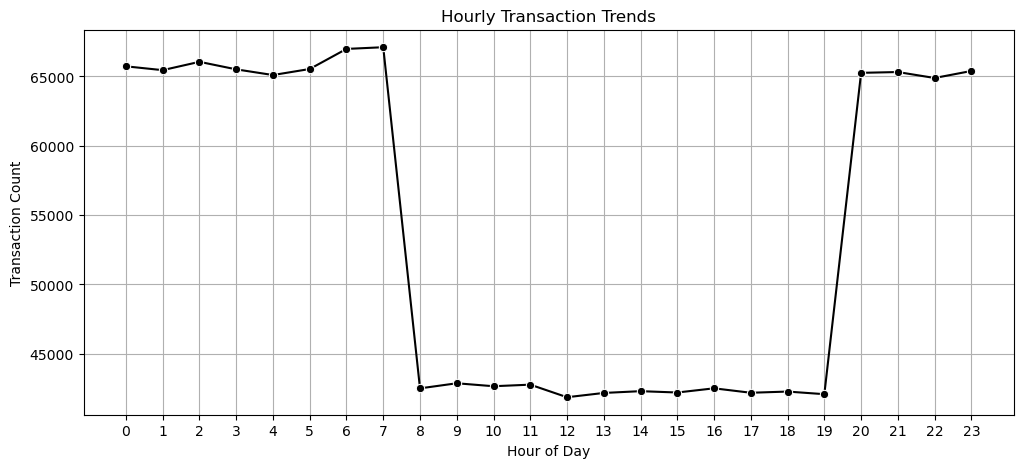

In [7]:
hourly_trends = df.withColumn("hour", hour(col("trans_date_trans_time"))).groupBy("hour").agg(count("*").alias("transaction_count"), sum("amt").alias("total_spent")).orderBy(col("hour"))
hourly_trends_pd = hourly_trends.toPandas()

plt.figure(figsize=(12, 5))
sns.lineplot(x="hour", y="transaction_count", data=hourly_trends_pd, color="black", marker="o", legend=False)
plt.title("Hourly Transaction Trends")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

* There is a high volume of transactions from 10 PM to 7 AM compared to other hours

###

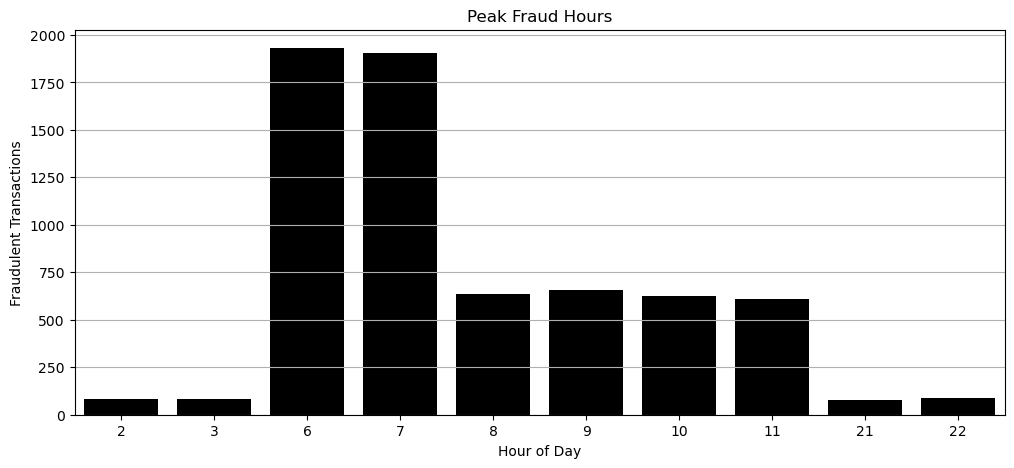

In [8]:
fraud_hourly = df.filter(col("is_fraud") == 1).withColumn("hour", hour(col("trans_date_trans_time"))).groupBy("hour").agg(count("*").alias("fraud_count"), sum("amt").alias("fraud_amount")).orderBy(col("fraud_count").desc())
fraud_hourly_pd = fraud_hourly.toPandas()

plt.figure(figsize=(12, 5))
sns.barplot(x="hour", y="fraud_count", data=fraud_hourly_pd.head(10), color="black", dodge=False)
plt.title("Peak Fraud Hours")
plt.xlabel("Hour of Day")
plt.ylabel("Fraudulent Transactions")
plt.grid(axis="y")
plt.show()

* From 10 PM to 7 AM, there is a high volume of fraudulent transactions at 6 AM and 7 AM

###

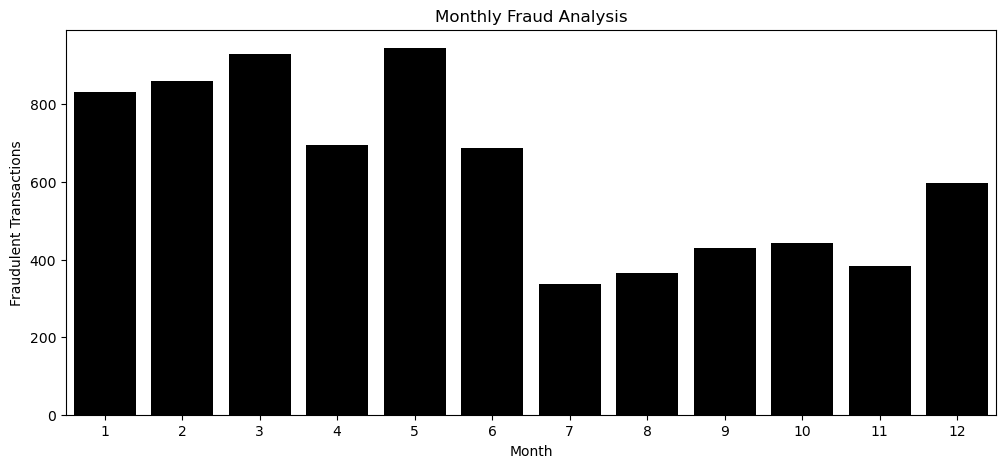

In [9]:
monthly_fraud = df.withColumn("month", month(col("trans_date_trans_time"))).groupBy("month").agg(count("*").alias("transaction_count"), sum(when(col("is_fraud") == 1, 1).otherwise(0)).alias("fraud_transactions"), round(sum(when(col("is_fraud") == 1, col("amt")).otherwise(0)), 2).alias("fraud_amount")).orderBy(col("month"))
monthly_fraud_pd = monthly_fraud.toPandas()

fig, ax1 = plt.subplots(figsize=(12, 5))
sns.barplot(x="month", y="fraud_transactions", data=monthly_fraud_pd, color="black", ax=ax1, dodge=False)
ax1.set_ylabel("Fraudulent Transactions")
ax1.set_xlabel("Month")
ax1.set_title("Monthly Fraud Analysis")
plt.show()

* There is a high volume of fraudulent transactions during the first half of the year

###

### Fraud Prevention Strategies

### Real-time fraud detection
* From the visualizations above, the average amount of fraudulent transaction is around 500$
* We can use this value as baseline to categorize the transactions, either High Risk, Medium Risk or Low Risk
* Transactions flagged as High Risk can be sent for manual review before approval

In [10]:
from pyspark.sql.functions import when

df = df.withColumn("fraud_risk", when((col("amt") > 500) & (col("is_fraud") == 1), "High").when((col("amt") > 300), "Medium").otherwise("Low"))
df.filter(col("fraud_risk") == "High").select(col("amt"), col("is_fraud"), col("fraud_risk")).show(10)

+-------+--------+----------+
|    amt|is_fraud|fraud_risk|
+-------+--------+----------+
| 930.63|       1|      High|
| 686.32|       1|      High|
|1073.49|       1|      High|
|1062.95|       1|      High|
| 791.02|       1|      High|
|1126.82|       1|      High|
|1160.14|       1|      High|
|1185.32|       1|      High|
| 861.36|       1|      High|
| 731.60|       1|      High|
+-------+--------+----------+
only showing top 10 rows



### Machine learning (Random Forest)
* Back in 2021, I built machine learning model (_pandas_ version) for credit card transaction data. Can refer this link: __[Credit Card Fraud Detection](https://github.com/alfredomarinus/portfolio/tree/master/Credit%20Card%20Fraud%20Detection)__
* _state_ and _job_ are removed because of their high cardinality as categorical columns

In [11]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

categorical_cols = ["gender", "category"]
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep") for col in categorical_cols]

numerical_cols = ["amt", "city_pop", "lat", "long", "merch_lat", "merch_long"]

feature_cols = numerical_cols + [f"{col}_index" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
forest = RandomForestClassifier(labelCol="is_fraud", featuresCol="features", numTrees=50, maxBins=64)

pipeline = Pipeline(stages=indexers + [assembler, scaler, forest])
model = pipeline.fit(df)
predictions = model.transform(df)

In [12]:
predictions.filter(col("is_fraud")==0).select("is_fraud", "prediction", "probability").show(10)

+--------+----------+--------------------+
|is_fraud|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.99705783490743...|
|       0|       0.0|[0.99707677477553...|
|       0|       0.0|[0.99843425323335...|
|       0|       0.0|[0.99797903860069...|
|       0|       0.0|[0.99759008830856...|
|       0|       0.0|[0.99820885597326...|
|       0|       0.0|[0.99815528779883...|
|       0|       0.0|[0.99798350680664...|
|       0|       0.0|[0.99779955459404...|
|       0|       0.0|[0.99707677477553...|
+--------+----------+--------------------+
only showing top 10 rows



In [13]:
predictions.filter(col("prediction")==1).select("is_fraud", "prediction", "probability").show(10)

+--------+----------+--------------------+
|is_fraud|prediction|         probability|
+--------+----------+--------------------+
|       1|       1.0|[0.40354753013783...|
|       1|       1.0|[0.44681139953347...|
|       1|       1.0|[0.42726734224803...|
|       1|       1.0|[0.47955549748638...|
|       1|       1.0|[0.46963315216524...|
|       1|       1.0|[0.48017620883199...|
|       1|       1.0|[0.40021229798963...|
|       1|       1.0|[0.44113956929582...|
|       1|       1.0|[0.44104175993971...|
|       1|       1.0|[0.46486716420616...|
+--------+----------+--------------------+
only showing top 10 rows



In [14]:
evaluators = {
    "accuracy": MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy"),
    "precision": MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedPrecision"),
    "recall": MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="weightedRecall"),
    "f1": MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="f1")
}

metrics = {metric: evaluator.evaluate(predictions) for metric, evaluator in evaluators.items()}

precision = metrics["precision"]
recall = metrics["recall"]

beta = 2
f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
metrics["f2"] = f2_score

In [15]:
metrics

{'accuracy': 0.995065070275898,
 'precision': 0.9950894446161909,
 'recall': 0.995065070275898,
 'f1': 0.99323798404927,
 'f2': 0.9950699450484296}

* High recall means less misclassification of fraudulent transactions as normal, less false negative
* High precision means less misclassification of normal transactions as fraudulent, less false positive
* False negative is more critical here. We can use F2-score as metric since it puts a higher weight on recall compare to precision